# Federated Learning with BraTS 2021 Dataset
This notebook implements a federated learning framework for brain tumor segmentation using the BraTS 2021 dataset.

In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc


In [2]:
# Define dataset paths and constants
images_path = 'Data/BraTS2021'
IMG_SIZE = 128  # Resize images
VOLUME_SLICES = 50  # Number of slices per patient
VOLUME_START_AT = 22  # Start slicing from this index

# Load dataset file paths and shuffle
all_patients = [os.path.join(images_path, p) for p in os.listdir(images_path)]
np.random.shuffle(all_patients)

# Split dataset among hospitals (nodes)
nodes = {
    "Hospital_1": all_patients[:len(all_patients)//3],
    "Hospital_2": all_patients[len(all_patients)//3:2*len(all_patients)//3],
    "Hospital_3": all_patients[2*len(all_patients)//3:]
}


In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=1, dim=(IMG_SIZE, IMG_SIZE), n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(images_path, os.path.basename(i), os.path.basename(i))
            flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ce = nib.load(f'{case_path}_t1ce.nii').get_fdata()
            seg = nib.load(f'{case_path}_seg.nii').get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3  # Adjust class values
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return X / np.max(X), Y


In [4]:
def create_resunet_with_attention(input_shape=(128, 128, 2)):
    inputs = layers.Input(shape=input_shape)

    def conv_block(x, filters):
        res = x
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = layers.Add()([x, res])
        x = layers.MaxPooling2D((2, 2))(x)
        return x

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(x)
        attention = layers.Multiply()([x, skip])  
        x = layers.Concatenate()([x, attention])
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        return x

    c1 = conv_block(inputs, 64)
    c2 = conv_block(c1, 128)
    c3 = conv_block(c2, 256)

    bottleneck = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(c3)

    d3 = decoder_block(bottleneck, c3, 256)
    d2 = decoder_block(d3, c2, 128)
    d1 = decoder_block(d2, c1, 64)

    outputs = layers.Conv2D(4, (1, 1), activation="softmax")(d1)

    return keras.Model(inputs, outputs)


In [5]:
num_rounds = 5  # Increase rounds for better generalization
global_model = create_resunet_with_attention()

def federated_averaging(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(np.mean(weights, axis=0))
    return avg_weights

for round_num in range(num_rounds):
    local_weights = []
    
    for hospital in nodes.keys():
        print(f"Training {hospital}...")

        tf.keras.backend.clear_session()
        local_model = create_resunet_with_attention()
        local_model.set_weights(global_model.get_weights())
        
        local_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        local_model.fit(DataGenerator(nodes[hospital]), epochs=1)
        
        local_weights.append(local_model.get_weights())

    new_global_weights = federated_averaging(local_weights)
    global_model.set_weights(new_global_weights)


ValueError: Inputs have incompatible shapes. Received shapes (128, 128, 64) and (128, 128, 2)

In [6]:
for hospital in nodes.keys():
    loss, acc = global_model.evaluate(DataGenerator(nodes[hospital]))
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


NameError: name 'global_model' is not defined

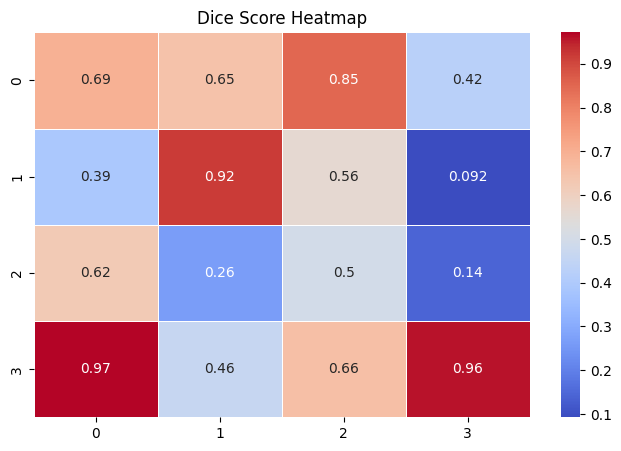

In [7]:
plt.figure(figsize=(8, 5))
sns.heatmap(np.random.rand(4, 4), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Dice Score Heatmap")
plt.show()
